# Evaluation

The goal of this lab is to introduce you to techniques for evaluating your trained models. The motivation is to be able to select the model that has the best (expected) out-of-sample prediction and to assess the quality of the model.

## 1. Model Selection in a holdout setting

We will work with the <a href="https://en.wikipedia.org/wiki/Iris_flower_data_set">Iris</a> data set. The iris data set consists out of $4$ features (sepal length, sepal width, petal length, petal width) of three kinds of flowers in the iris family: iris setosa, iris versicolor, iris virginica. Our version of the data set has 150 data points with 50 for each class.

In [1]:
# Load the data...
%matplotlib inline

import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold

iris = load_iris()
print('Loaded {} data points'.format(len(iris.data)))

X, y = iris.data, iris.target

print('Class labels: {}'.format(list(zip(range(3), iris.target_names))))

Loaded 150 data points
Class labels: [(0, 'setosa'), (1, 'versicolor'), (2, 'virginica')]


We try to classify the iris versicolor with the help of the first two features.

In [2]:
import numpy as np

X_versi = X[:, :2] 
y_versi = np.zeros(len(y))
y_versi[y == 1] = 1

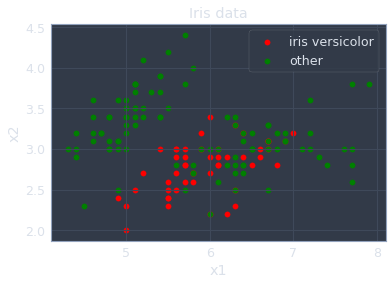

In [4]:
# plot iris data with two features
plt.scatter(X_versi[y_versi == 1, 0], X_versi[y_versi == 1, 1], c='red', label='iris versicolor')
plt.scatter(X_versi[y_versi == 0, 0], X_versi[y_versi == 0, 1], c='green', label='other')
plt.xlabel("x1")
plt.ylabel("x2")
plt.title('Iris data')
plt.legend()

We split the data into a train and test (holdout) set with a split ratio of 75% to 25%.

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_versi, y_versi, test_size=0.25, random_state=3)

The following function is a little visualization helper that draws the values of the decision function on a heat map given a matplotlib axe.

In [6]:
def show_decision_function(clf, ax):
    xx, yy = np.meshgrid(np.linspace(4.5, 8, 200), np.linspace(1.5, 4.0, 200))
    try:
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    except AttributeError:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]

    Z = Z.reshape(xx.shape)
    ax.pcolormesh(xx, yy, Z, cmap=plt.cm.jet)
    ax.set_xlim(4.5, 8)
    ax.set_ylim(1.5, 4.0)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=100)

We now train a SVM classifier on the training data and plot its decision boundary.

Text(0.5, 1.0, 'Decision function of a SVM classifier with gamma = 10, C = 1')

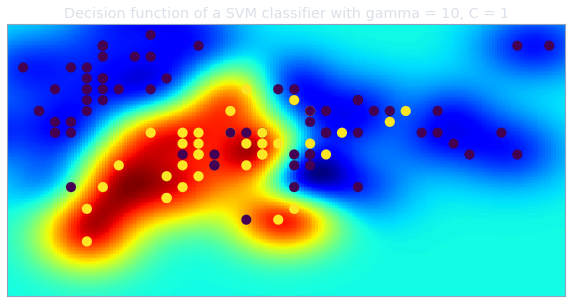

In [7]:
from sklearn.svm import SVC

clf_svm = SVC(gamma=10, C=1)
clf_svm.fit(X_train, y_train)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
show_decision_function(clf_svm, ax)
ax.set_title('Decision function of a SVM classifier with gamma = 10, C = 1')

#### Exercise 1.1 (Performance measures)
Classify the test data and evaluate the classification performance of the trained model 'clf_svm' using the scikit-learn metrics package. Compare various metrics (classification accuracy, precision, recall, f-score), interpret their values and argue which of them might be the most meaningful to report.

In [8]:
# predict labels
y_hat = clf_svm.predict(X_test)

In [9]:
# Accuracy of SVM
acc = metrics.accuracy_score(y_test, y_hat)
print('Accuracy: ', acc)

# Precision
prec = metrics.precision_score(y_test, y_hat)
print('Precision: ', prec)

# Recall
rec = metrics.recall_score(y_test, y_hat)
print('Recall: ', rec)

# F1

f1 = metrics.f1_score(y_test, y_hat)
print('F1: ', f1)

Accuracy:  0.7631578947368421
Precision:  0.6666666666666666
Recall:  0.5
F1:  0.5714285714285715


In [10]:
# Error rate/accuracy is not meaningful for rare classes
target_names = ['other', 'iris versicolor']
report = metrics.classification_report(y_test, y_hat, target_names=target_names)
print(report)

                 precision    recall  f1-score   support

          other       0.79      0.88      0.84        26
iris versicolor       0.67      0.50      0.57        12

      micro avg       0.76      0.76      0.76        38
      macro avg       0.73      0.69      0.70        38
   weighted avg       0.75      0.76      0.75        38



**Answer to Q1:**  
All of the measures are better for classifying 'other' in comparison to 'iris versicolor'. 3/4 of the test data is indeed 'other', so it's more likely that a piece of test data will indeed be with the label 'other'.

*Precision*: TP/TP+FP  
How accurate is the classifier when it classifies smth positive?   
TP/TP+FP  

*Recall*:   
How many of the positive instances does classifier detect?   
TP/TP+FN

Unbalanced dataset: accuracy is not a good measure. If a label occurs more often in a data. Even if the model just guesses, it will more likely be correct.

We use ROC in case of the unbalanced dataset. 

Classifying a random positive example more positively than a negative one.

#### Exercise 1.2 (ROC curve)

To further evaluate the model, we want to plot a ROC (Receiver operating characteristic) curve and look at the AUC (area under the curve) value. Therefore, we provide a function "plot_roc_curves" that accepts increasing false positive rates (fprs) and true positive rates (tprs) and plots the curve for you. 

Please calculate the false and true positive rates of the classifier 'clf_svm' on the test data 'X_test' and draw the ROC curve by executing the function 'plot_roc_curves'. What does the ROC and AUC tell us about the classifier's performance?

In [11]:
# helper to plot ROC curves
def plot_roc_curves(fprs, tprs):    
    fig = plt.figure(figsize=(20,10))
    
    for fpr, tpr in zip(fprs, tprs):
        plt.plot(fpr, tpr, label='RO  C curve (AUC = %0.2f)' % metrics.auc(fpr, tpr))
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

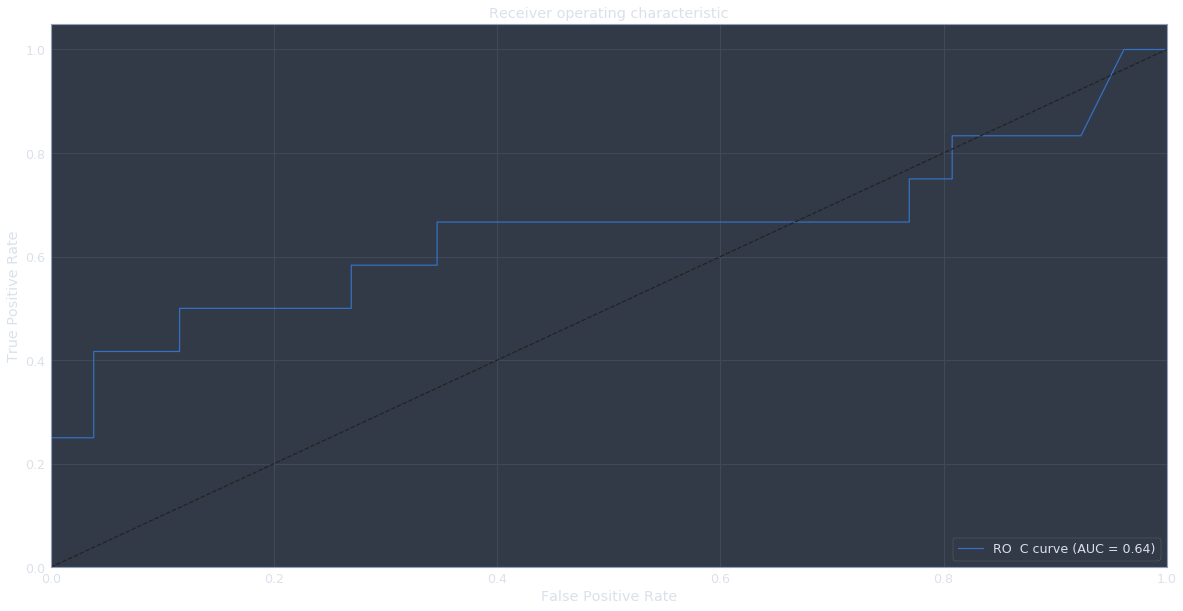

In [12]:
y_score = clf_svm.decision_function(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score, pos_label=1)

# plot the curve
plot_roc_curves([fpr], [tpr])

**What does the ROC and AUC tell us about the classifier's performance?**  
Receiver Operator haracteristic: summerizes confusion matrices for different threshholds.
True Positive Rate = True Positives     
False positive Rate = False Positives / False Positives + True Negatives (want this to stay zero)
We analyse ROC when positive instances are rare (1/3 of teh data). 

#### Exercise 1.3 (Model comparison)

Train four more SVM models on the training data by varying the regularization parameter $C$ (the gamma parameter can be set to 10 again). Put the models into a list 'clfs' using the append method. You can add a name to each classifier by setting clf.name = "some description" to keep track of the configuration.

In [13]:
clfs = []
C = [1,5,7,15]

for regularizer in C:
    clf_svm = SVC(gamma=10, C=regularizer)
    clf_svm.fit(X_train, y_train)
#     clf_svm.predict(y_test)
    clf_svm.name = "reg{}".format(regularizer)
    clfs.append(clf_svm)

Let's have a look at the decision functions of the four classifiers...

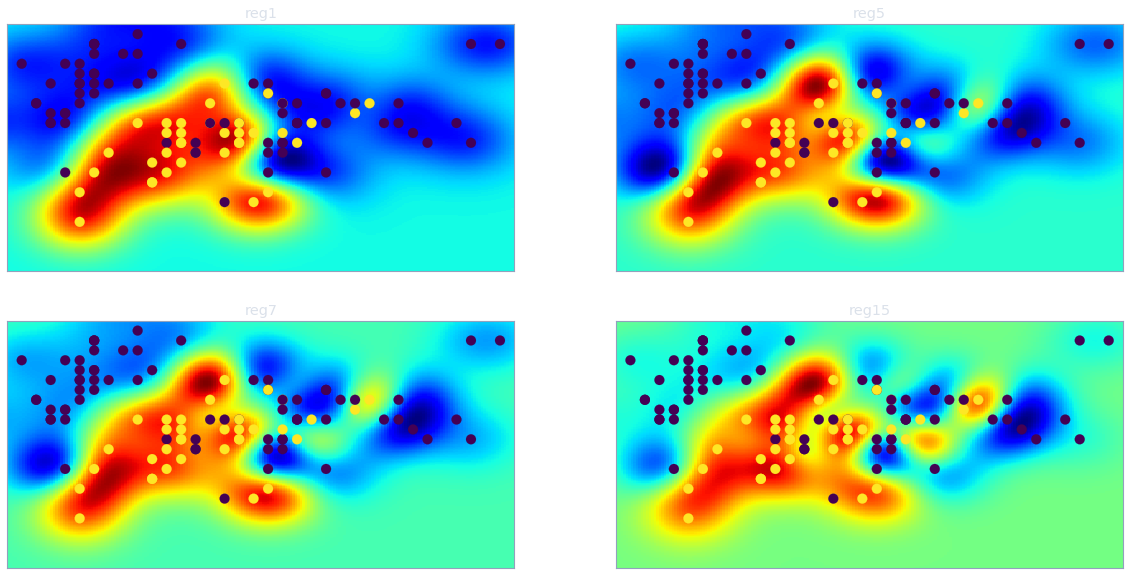

In [14]:
# visualize the decision functions of the four different classifiers
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

for clf, ax in zip(clfs, axes.ravel()):
    show_decision_function(clf, ax)
    ax.set_title(clf.name)

... and draw the ROC curves.

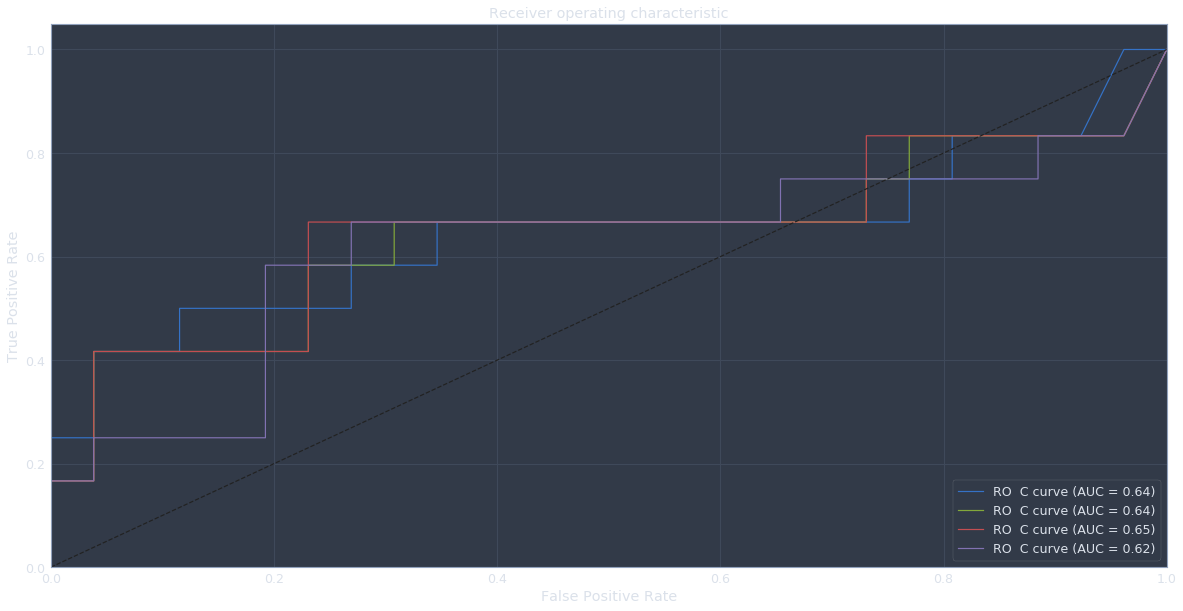

In [15]:
# draw the roc curves:

fprs, tprs = [], []

for clf in clfs:
    y_score = clf.decision_function(X_test)
    fpr, tpr, _ = metrics.roc_curve(y_test, y_score, pos_label=1)
    fprs.append(fpr)
    tprs.append(tpr)
    
plot_roc_curves(fprs, tprs)